In [0]:
## Imports
import numpy as np
import pandas as pd
import random as rnd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import time 
import pylab as pl
import warnings
import xgboost as xgb
warnings.filterwarnings("ignore")

%matplotlib inline

from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

Pclass : A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

Age : Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

Sibsp : The dataset defines family relations in this way...
- Sibling = brother, sister, stepbrother, stepsister
- Spouse = husband, wife (mistresses and fiancés were ignored)

Parch : The dataset defines family relations in this way...
- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore Parch=0 for them.

Embarked : C = Cherbourg, Q = Queenstown, S = Southampton

In [0]:
## Test data
test_titanic = pd.read_csv('C:/Users/Devignes/Desktop/Semestre 9/PRDL/Projet/test.csv')
test_titanic.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [0]:
## Train data
train_titanic = pd.read_csv('C:/Users/Devignes/Desktop/Semestre 9/PRDL/Projet/train.csv')
train_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
## Submission
gender = pd.read_csv('C:/Users/Devignes/Desktop/Semestre 9/PRDL/Projet/gender_submission.csv')
gender.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [0]:
#We extract the title of the people from the variable Name
train_titanic['Title'] = train_titanic.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
test_titanic['Title'] = test_titanic.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(train_titanic['Title'], train_titanic['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [0]:
#As there is a lot of modalities with few appearences, we are going to group them
train_titanic['Title'] = train_titanic['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
#We replaced some formulations by others which are the same
train_titanic['Title'] = train_titanic['Title'].replace('Mlle', 'Miss')
train_titanic['Title'] = train_titanic['Title'].replace('Ms', 'Miss')
train_titanic['Title'] = train_titanic['Title'].replace('Mme', 'Mrs')

test_titanic['Title'] = test_titanic['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test_titanic['Title'] = test_titanic['Title'].replace('Mlle', 'Miss')
test_titanic['Title'] = test_titanic['Title'].replace('Ms', 'Miss')
test_titanic['Title'] = test_titanic['Title'].replace('Mme', 'Mrs')
pd.crosstab(train_titanic['Title'], train_titanic['Sex'])

Sex,female,male
Title,,
Master,0,40
Miss,185,0
Mr,0,517
Mrs,126,0
Rare,3,20


In [0]:
#We modify the modalities to be able to take in account our variable in the model
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
train_titanic['Title'] = train_titanic['Title'].map(title_mapping)
train_titanic['Title'] = train_titanic['Title'].fillna(0)
test_titanic['Title'] = test_titanic['Title'].map(title_mapping)
test_titanic['Title'] = test_titanic['Title'].fillna(0)
train_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


Logistic Regression
Neural Networks
Random Forest
SVM
KNN
Logistic Regression with XGBoost

In [0]:
#We drop the variables we are not going to use
train_titanic.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis = 1, inplace = True)
test_titanic.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis = 1, inplace = True)

In [0]:
#We replace the missing values by the mode for the variable "Embarked"
freq_port = train_titanic.Embarked.dropna().mode()[0]
freq_port
train_titanic['Embarked'] = train_titanic['Embarked'].fillna(freq_port)
#We modify the modalities to be able to take in account our variable in the model
train_titanic["Embarked"] = train_titanic["Embarked"].map( {"S": 0, "C": 1, "Q": 2} ).astype(int)
freq_port = test_titanic.Embarked.dropna().mode()[0]
freq_port
test_titanic['Embarked'] = test_titanic['Embarked'].fillna(freq_port)
test_titanic["Embarked"] = test_titanic["Embarked"].map( {"S": 0, "C": 1, "Q": 2} ).astype(int)

In [0]:
#We replace the missing values by the median for the variable "Age"
med = train_titanic.Age.dropna().median()
med
train_titanic['Age'] = train_titanic['Age'].fillna(med)
med = test_titanic.Age.dropna().median()
med
test_titanic['Age'] = test_titanic['Age'].fillna(med)

In [0]:
#We replace the missing values by the median for the variable "Fare"
med = train_titanic.Fare.dropna().median()
med
train_titanic['Fare'] = train_titanic['Fare'].fillna(med)
med = test_titanic.Fare.dropna().median()
med
test_titanic['Fare'] = test_titanic['Fare'].fillna(med)

In [0]:
#We modify the modalities to be able to take in account our variable in the model
train_titanic["Sex"] = train_titanic["Sex"].map( {"female": 0, "male": 1} ).astype(int)
test_titanic["Sex"] = test_titanic["Sex"].map( {"female": 0, "male": 1} ).astype(int)

In [0]:
train_titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,1,22.0,1,0,7.2500,0,1
1,1,1,0,38.0,1,0,71.2833,1,3
2,1,3,0,26.0,0,0,7.9250,0,2
3,1,1,0,35.0,1,0,53.1000,0,3
4,0,3,1,35.0,0,0,8.0500,0,1


In [0]:
#We create our subsets
#REALLY CREATE A TRAIN AND TEST DATASETS
#y = train_titanic["Survived"].copy()
#X = train_titanic.drop(["Survived"], axis = 1).copy()
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
y_train = train_titanic["Survived"]
X_train = train_titanic.drop(["Survived"], axis = 1)
X_test = test_titanic
y_test = gender["Survived"]

In [0]:
#Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
acc_log = round(np.mean(cross_val_score(logreg, X_train, y_train, scoring='accuracy',cv=5))*100, 2)
acc_log

80.58

In [0]:
#Support Vector Classification
svc = SVC()
svc.fit(X_train, y_train)
acc_svc = round(np.mean(cross_val_score(svc, X_train, y_train, scoring='accuracy',cv=5))*100, 2)
acc_svc

72.63

In [0]:
#Multi-Layer Perceptron Classification (Neural Network)
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
acc_mlp = round(np.mean(cross_val_score(mlp, X_train, y_train, scoring='accuracy',cv=5))*100, 2)
acc_mlp

75.32

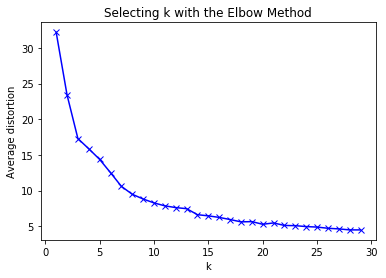

In [0]:
#We are going to select the best k for our KNearestNeighbors model
K = range(1, 30)
meandistortions = []
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train, y_train)
    meandistortions.append(sum(np.min(cdist(X_train, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X_train.shape[0])
plt.plot(K, meandistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')
plt.show()
#We can see that there is a clear elbow in the curve at k = 3, so we are going to select this value

In [0]:
#KNearestNeighbors
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
acc_knn = round(np.mean(cross_val_score(knn, X_train, y_train, scoring='accuracy',cv=5))*100, 2)
acc_knn

71.27

In [0]:
#Decicion Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
acc_decision_tree = round(np.mean(cross_val_score(decision_tree, X_train, y_train, scoring='accuracy',cv=5))*100, 2)
acc_decision_tree

77.67

In [0]:
#Random Forest
random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(X_train, y_train)
acc_random_forest = round(np.mean(cross_val_score(random_forest, X_train, y_train, scoring='accuracy',cv=5))*100, 2)
acc_random_forest

81.03

In [0]:
#XGBClassifier
xgbclas = XGBClassifier()
xgbclas.fit(X_train, y_train)
acc_xgbclas = round(np.mean(cross_val_score(xgbclas, X_train, y_train, scoring='accuracy',cv=5))*100, 2)
acc_xgbclas

83.5

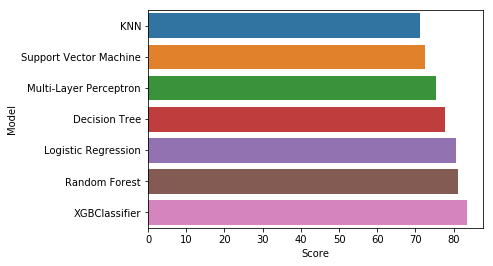

In [0]:
models = pd.DataFrame({
    'Model': ['Support Vector Machine', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Multi-Layer Perceptron', 
              'XGBClassifier', 'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_mlp, 
              acc_xgbclas, acc_decision_tree]})
models.sort_values(by='Score', inplace=True)
sns.barplot(x="Score", y="Model", data=models)

In [0]:
#Initialization of learning_rate and n_estimators
xgbclas = XGBClassifier(learning_rate =0.1, n_estimators = 300)
xgbclas.fit(X_train, y_train)
acc_xgbclas = round(np.mean(cross_val_score(xgbclas, X_train, y_train, scoring='accuracy',cv=5))*100, 2)
acc_xgbclas

84.96

In [0]:
#Tuning parameters
start_time = time.time()
params = {
        'max_depth' : [5,6,7],
        'min_child_weight' : [4,5,6],
        'max_delta_step': [0,1,2],
        'subsample' : [0.7,0.8,0.9],
        'colsample_bytree' : [0.7,0.8,0.9],
        'gamma': [0.3,0.4,0.5]
        }
gsearch1 = GridSearchCV(estimator = xgbclas, param_grid = params, scoring='accuracy', cv = 5)
gsearch1.fit(X_train, y_train)
print(round(gsearch1.best_score_*100,2), "%")
print(gsearch1.best_estimator_)
print("Execution time : %s seconds ---" % (time.time() - start_time))

85.41 %
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0.5, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=5, missing=None,
       n_estimators=300, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)
Temps d execution : 680.2563998699188 secondes ---


In [0]:
#RandomizedSearchCV
start_time = time.time()
acc_best = 0.0
params = {
        'subsample': pl.frange(0,1,0.1),
        'colsample_bytree': pl.frange(0.1,1,0.1),
        'gamma': pl.frange(0,1,0.1),
        'max_depth': range(1, 10),
        'min_child_weight': range(0, 10),
        'max_delta_step': range(1, 10)
}
best_model = XGBClassifier()
gsearch2 = RandomizedSearchCV(estimator = xgbclas, param_distributions = params, scoring='accuracy', n_iter = 100, cv = 5)
gsearch2.fit(X_train, y_train)
print(round(gsearch2.best_score_*100,2), "%")
print(gsearch2.best_estimator_)
print("Execution time : %s seconds ---" % (time.time() - start_time))

85.41 %
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.30000000000000004, learning_rate=0.1,
       max_delta_step=3, max_depth=5, min_child_weight=6, missing=None,
       n_estimators=300, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9)
Execution time : 53.4994170665741 seconds ---


In [0]:
xgbclas = gsearch2.best_estimator_

In [0]:
xgbclas.fit(X_train, y_train)
y_pred = xgbclas.predict(X_test)
gender["Survived"] = y_pred
gender.to_csv('submission_xgboost2.csv', index=False)

In [0]:
y_pred = decision_tree.predict(X_test)
gender["Survived"] = y_pred
gender.to_csv('submission_decision_tree.csv', index=False)

In [0]:
y_pred = random_forest.predict(X_test)
gender["Survived"] = y_pred
gender.to_csv('submission_random_forest.csv', index=False)

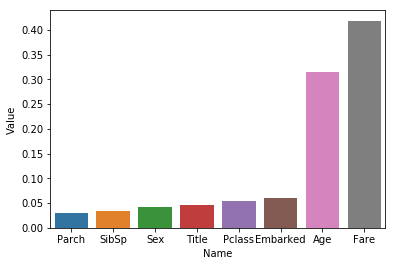

In [0]:
d = {'Name' : X_train.columns,
     'Value' : xgbclas.feature_importances_}
features = pd.DataFrame(d)
features = features.set_index('Name')
features = features.sort_values("Value")
sns.barplot(features.index, features.Value)

Models : 

- Logistic Regression
- Decision Trees
- Random Forests
- SVM
- XGBoost
- KNN
- Neural Networks

Parameters XGBClassifier() : 

- learning_rate [0,1] default 0.3
- subsample [0, 1] default 1
- colsample_bytree (0, 1] default 1
- gamma [0, infini] default 0
- max_depth [1, infini] default 6
- min_child_weight [0, infini] default 1
- max_delta_step [0, infini] default 0 (?)
- n_estimators [1, infini] default 100
- reg_alpha default 0
- reg-lambda default 1

Step 1 : learning_rate & n_estimators
Step 2 : max_depth & min_child_weight
Step 3 : gamma
Step 4 : subsample & colsample_bytree
Step 5 : Regularization Parameters (reg_alpha or reg_lambda)
Step 6 : Reducing learning_rate